# Splitting the board into squares

In [1]:
import sys
sys.path.append("../")
from putzlib import *

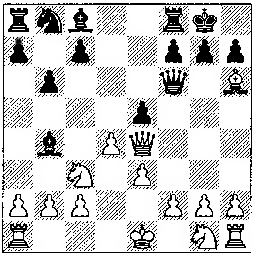

In [2]:
im = Image.open('./examples/Clipboard03.png').convert('L')
im.resize((256,256))

A scanned image with some typical artifacts. We want to locate the boundary, split the interior into 64 squares, and ignore the rest. **Problem**: the boundary lines are not continuous and there might be more than one enclosing box.

First we use the *Canny* algorithm to find the edges in the image. A good explanation of Canny with sample code can be found [here](http://pythongeek.blogspot.de/2012/06/canny-edge-detection.html). 

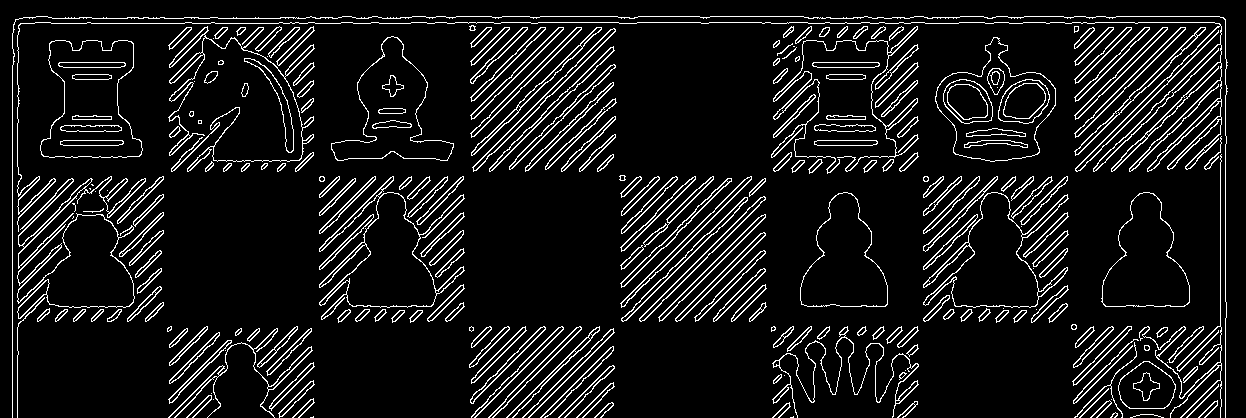

In [3]:
ima = np.asarray(im).astype(np.uint8)
l,w = ima.shape
imablur = cv2.GaussianBlur(ima,(5,5),0) #blurring closes up some lines
edges = cv2.Canny(imablur,200,400,apertureSize = 5)
Image.fromarray(edges[:l//3,:])

In [9]:
_,contours,_ = cv2.findContours(edges, 1, 2)
#keep the largest contours
boxes = [c for c in contours if cv2.contourArea(c)>.8*l*w] 
len(boxes)

2

Some of the the contours might not rectangular eg. they might bleed in to the interior of the board. So we compare the length and area to make sure.

In [10]:
areas = [cv2.contourArea(b) for b in boxes]
arcareas = [(cv2.arcLength(b,True)/4)**2 for b in boxes]
sqboxes = [b for i,b in enumerate(boxes) if (1-areas[i]/arcareas[i])<.1]
len(sqboxes)

2

Of the large rectangular contours, pick the innermost one.

In [11]:
if sqboxes:
    sqareas = [cv2.contourArea(b) for b in sqboxes]
    inbox = sqboxes[np.argmin(sqareas)]

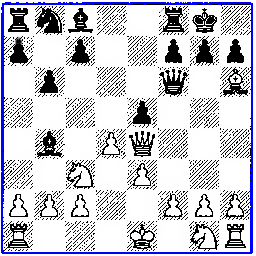

In [12]:
imacol = cv2.cvtColor(ima,cv2.COLOR_GRAY2BGR)
cv2.drawContours(imacol,[inbox],-1,(0,0,255),10)
Image.fromarray(imacol).resize((256,256))

Look fine! Right now the contour is just a closed circuit of (x,y) points. Here we could use `cv2.boundingRect(inbox)` to get the corners of the rectangle that bounds our contour and go from there. This will *not* work if the contour bulges appreciably at the corners or elsewhere. In those cases we will end up with a slightly larger rectangle. 

![contourbox](./examples/contourbound.png)

**Does it matter?** Unfortunately, yes. A rough estimate: if the calculated distance between adjacent squares is off by 1, that gives an offset of 8 pixels for squares on the edge of the chessboard. The smallest squares are ~ 30 x 30 so we would have cut off 25% of the image. 

The function `contourbox` makes best fit lines for all four sides of the `inbox` contour that we found previously.

Finally we divide length and width by 8 and get an array of 64 squares.

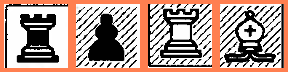

In [4]:
(up,down,left,right)=contourbox(ima)
xw,yw = int(round((down-up)/8)),int(round((right-left)/8))
squares = [ima[up+j*xw:up+(j+1)*xw,left+i*yw:left+(i+1)*yw] for j in range(8) for i in range(8)]
Image.fromarray(imagerowborder([squares[i] for i in (0,14,56,23)],finshape=(64,64)))

Some squares do include a bit of the boundary, but that's good enough.

## Other ways (and dead ends)

Initially I used the [Hough transform](https://en.wikipedia.org/wiki/Hough_transform) to find vertical and horizontal lines in the image. I thought this would be more reliable since it does not depend on the chessboard having a distinct border.

Unfortunately this needs careful tuning of the parameter for minimum line length for `cv2.HoughLines`. Too low and you get spurious lines running through the middle of a square which not always simple to filter out. Too high and not enough lines are detected.  

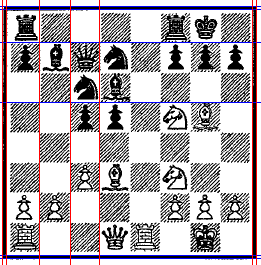

In [10]:
im2=Image.open('../boards3/Clipboard13.png').convert('L')
ima2=np.asarray(im2)

l,w = ima2.shape
hlines,vlines,(up,down),(left,right) = houghbox(ima2)
imacol2 = cv2.cvtColor(ima2,cv2.COLOR_GRAY2BGR)
thickness = 1
for i in hlines:
    cv2.line(imacol2,(0,i),(w,i),(0,0,255),thickness)
for j in vlines:
    cv2.line(imacol2,(j,0),(j,l),(255,0,0),thickness)

Image.fromarray(imacol2)